# LIME for tabular data with Dalex

- [Online Course](https://www.trainindata.com/p/machine-learning-interpretability)

Let's train an xgboost model on tabular data and explain it with LIME. 

We will use Dalex.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
import dalex as dx 

### Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


### Split data

In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((14448, 8), (6192, 8))

## XGBoost

In [4]:
# fit model

gbm = XGBRegressor(
    importance_type="gain",
    n_estimators=50,
    max_depth=3,
    random_state=3,
)

gbm.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type='gain',
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=3, ...)

In [5]:
# R2 in train set

gbm.score(X_train, y_train)

0.8195393445915184

In [6]:
# R2 in test set

gbm.score(X_test, y_test)

0.792226727552409

The model explains ~80% of the variability in the target variable.

## Global explanations - feature importance

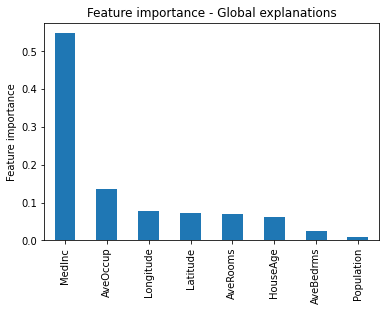

In [7]:
# gbm importance

global_exp = pd.Series(gbm.feature_importances_, index=gbm.feature_names_in_)

global_exp.sort_values(ascending=False).plot.bar()
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.show()

## Local explanations

In [8]:
import eli5

In [9]:
# pick one observation

sample_id = 14740

X_test.loc[sample_id]

MedInc           4.151800
HouseAge        22.000000
AveRooms         5.663073
AveBedrms        1.075472
Population    1551.000000
AveOccup         4.180593
Latitude        32.580000
Longitude     -117.050000
Name: 14740, dtype: float64

In [10]:
# feature contribution for 1 sample

eli5.show_prediction(
    gbm, 
    X_test.loc[sample_id], 
    feature_names=gbm.feature_names_in_,
)

## LIME with Dalex

In [11]:
# set up explainer

explain_gbm = dx.Explainer(gbm, data=X_train, y=y_train)

Preparation of a new explainer is initiated

  -> data              : 14448 rows 8 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 14448 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x000001E36265E710> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = -0.000731, mean = 2.07, max = 5.91
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -2.94, mean = -2.25e-05, max = 3.56
  -> model_info        : package xgboost

A new explainer has been created!


In [12]:
# Performance metrics on the test set

explain_gbm.model_performance().result

,mse,rmse,r2,mae,mad
XGBRegressor,0.240162,0.490063,0.819539,0.34219,0.241331


We need to "train" the explainer.

- Find out the frequency of the categories in categorical variables
- Find mean and standard deviation in numerical variables.
- Discretize numerical variables (optional)

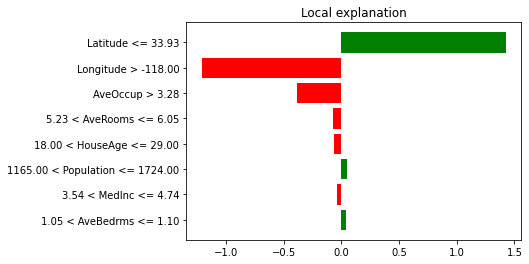

In [13]:
lime = explain_gbm.predict_surrogate(X_test.loc[sample_id], type="lime")

lime.plot()